<div class='alert alert-warning'>

# JupyterLite warning

If you are running the current notebook in JupyterLite, you may encounter some unexpected behavior.

The main difference is that imports take longer than usual, for example the first `import sklearn` can take up to 10-20s.

If you notice problems, feel free to open an [issue](https://github.com/probabl-ai/youtube-appendix/issues/new/choose) about it.
</div>

In [ ]:
%pip install skrub polars pyodide-http
import pyodide_http
from sklearn.datasets import fetch_openml

pyodide_http.patch_all()
X, y = fetch_openml(data_id=42125, return_X_y=True)
X

,full_name,gender,2016_gross_pay_received,2016_overtime_pay,department,department_name,division,assignment_category,employee_position_title,underfilled_job_title,date_first_hired,year_first_hired
0,"Aarhus, Pam J.",F,71225.98,416.10,POL,Department of Police,MSB Information Mgmt and Tech Division Records...,Fulltime-Regular,Office Services Coordinator,NaN,09/22/1986,1986
1,"Aaron, David J.",M,103088.48,3326.19,POL,Department of Police,ISB Major Crimes Division Fugitive Section,Fulltime-Regular,Master Police Officer,NaN,09/12/1988,1988
2,"Aaron, Marsha M.",F,107000.24,1353.32,HHS,Department of Health and Human Services,Adult Protective and Case Management Services,Fulltime-Regular,Social Worker IV,NaN,11/19/1989,1989
3,"Ababio, Godfred A.",M,57819.04,3423.07,COR,Correction and Rehabilitation,PRRS Facility and Security,Fulltime-Regular,Resident Supervisor II,NaN,05/05/2014,2014
4,"Ababu, Essayas",M,95815.17,NaN,HCA,Department of Housing and Community Affairs,Affordable Housing Programs,Fulltime-Regular,Planning Specialist III,NaN,03/05/2007,2007
...,...,...,...,...,...,...,...,...,...,...,...,...
9223,"Zurita, Justina",F,58154.47,NaN,HHS,Department of Health and Human Services,School Based Health Centers,Fulltime-Regular,Community Health Nurse II,NaN,11/03/2015,2015
9224,"Zuspan, Diane M.",F,173173.01,956.97,FRS,Fire and Rescue Services,Human Resources Division,Fulltime-Regular,Fire/Rescue Division Chief,NaN,11/28/1988,1988
9225,"Zwerdling, David",M,104238.18,NaN,HHS,Department of Health and Human Services,Child and Adolescent Mental Health Clinic Serv...,Parttime-Regular,Medical Doctor IV - Psychiatrist,NaN,04/30/2001,2001
9226,"Zyontz, Jeffrey L.",M,149105.25,NaN,CCL,County Council,Council Central Staff,Fulltime-Regular,Manager II,NaN,09/05/2006,2006


In [2]:
X_dirty = X[["employee_position_title"]]

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
    CountVectorizer(analyzer="char_wb", ngram_range=(2, 3)), 
)

x_dirty_list = list(X_dirty['employee_position_title'])
X_enc = pipe.fit_transform(x_dirty_list)
X_enc.shape

(9228, 1447)

In [4]:
from sklearn.metrics.pairwise import euclidean_distances

titles = [
 'District Supervisor',
 'Labor Relations Advisor',
 'Land Survey Supervisor',
 'Psychologist Supervisor',
 'Resident Supervisor I',
 'Revenue Counter Supervisor',
 'Senior Architect',
 'Senior Engineer',
 'Senior Investment Analyst',
 'Senior Latent Print Examiner',
 'Senior Retirement Analyst',
 'Supervisor Parking Meter Unit',
 'Warehouse Worker',
 'Work Force Leader IV'
]

dists = euclidean_distances(pipe.transform(["senior software architect"]), pipe.transform(titles))
for d, t in zip(dists[0], titles):
    print(t, d)

District Supervisor 8.366600265340756
Labor Relations Advisor 9.0
Land Survey Supervisor 9.1104335791443
Psychologist Supervisor 8.94427190999916
Resident Supervisor I 8.426149773176359
Revenue Counter Supervisor 9.0
Senior Architect 3.4641016151377544
Senior Engineer 7.0710678118654755
Senior Investment Analyst 8.18535277187245
Senior Latent Print Examiner 8.717797887081348
Senior Retirement Analyst 7.937253933193772
Supervisor Parking Meter Unit 9.055385138137417
Warehouse Worker 7.874007874011811
Work Force Leader IV 8.831760866327848


In [5]:
from sklearn.decomposition import PCA

X_sparse = CountVectorizer(analyzer="char_wb", ngram_range=(2, 4)).fit_transform(x_dirty_list)
pca = PCA(n_components=10, svd_solver='arpack').fit(X_sparse)
pca.transform(X_sparse).shape

(9228, 10)

In [6]:
import numpy as np 

np.abs(pca.inverse_transform(pca.transform(X_sparse)) - X_sparse).sum()

np.float64(714971.190221992)

In [7]:
data = []
for size in [5, 10, 20, 50, 100, 200, 500, 1000]:
    pca = PCA(n_components=size, svd_solver='arpack').fit(X_sparse)
    data.append({
        'size': size,
        'diff': np.abs(pca.inverse_transform(pca.transform(X_sparse)) - X_sparse).sum(),
    })

In [ ]:
import matplotlib
import polars as pl 

pl.DataFrame(data).plot.line("size", "diff")

alt.Chart(...)

In [8]:
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
    CountVectorizer(analyzer="char_wb", ngram_range=(2, 4)), 
    PCA(n_components=50, svd_solver='arpack')
)

x_dirty_list = list(X_dirty['employee_position_title'])
X_enc = pipe.fit_transform(x_dirty_list)
X_enc.shape

(9228, 50)

In [9]:
from sklearn.metrics.pairwise import euclidean_distances

titles = [
 'District Supervisor',
 'Labor Relations Advisor',
 'Land Survey Supervisor',
 'Psychologist Supervisor',
 'Resident Supervisor I',
 'Revenue Counter Supervisor',
 'Senior Architect',
 'Senior Engineer',
 'Senior Investment Analyst',
 'Senior Latent Print Examiner',
 'Senior Retirement Analyst',
 'Supervisor Parking Meter Unit',
 'Warehouse Worker',
 'Work Force Leader IV'
]

dists = euclidean_distances(pipe.transform(["distract supervisor"]), pipe.transform(titles))
for d, t in sorted(zip(dists[0], titles), key=lambda d: d[0]):
    print(t, d)

District Supervisor 1.363866569606806
Psychologist Supervisor 2.4026346505482827
Land Survey Supervisor 2.7594830512310424
Resident Supervisor I 3.609492109599848
Supervisor Parking Meter Unit 3.972651929997475
Revenue Counter Supervisor 4.240512594236093
Labor Relations Advisor 5.202436090631291
Senior Architect 6.756341897466552
Senior Investment Analyst 7.448234390054269
Senior Retirement Analyst 7.744758099326546
Senior Latent Print Examiner 7.751065088998287
Warehouse Worker 7.766881431603538
Senior Engineer 7.864074943087292
Work Force Leader IV 8.183386543632981


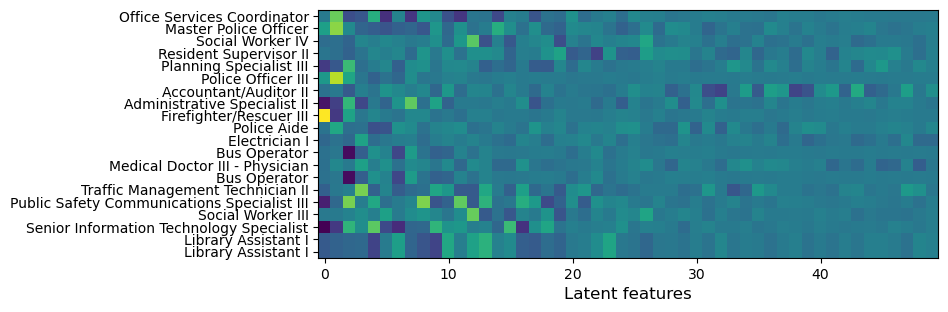

In [10]:
import matplotlib.pyplot as plt

encoded_labels = pipe.transform(x_dirty_list[:20])
plt.figure(figsize=(8, 10))
plt.imshow(encoded_labels)
plt.xlabel("Latent features", size=12)
plt.yticks(range(0, 20), labels=X_dirty[:20].to_numpy().flatten())
plt.show()

In [12]:
from skrub import GapEncoder

enc = GapEncoder(n_components=10, random_state=1)
X_enc = enc.fit_transform(X_dirty['employee_position_title'])
X_enc.shape

(9228, 10)

In [13]:
topic_labels = enc.get_feature_names_out(n_labels=3)
for k, labels in enumerate(topic_labels):
    print(f"Topic n°{k}: {labels}")

Topic n°0: employee_position_title: administrative, specialist, principal
Topic n°1: employee_position_title: manager, sheriff, deputy
Topic n°2: employee_position_title: officer, police, office
Topic n°3: employee_position_title: coordinator, equipment, operator
Topic n°4: employee_position_title: community, health, school
Topic n°5: employee_position_title: technology, information, enforcement
Topic n°6: employee_position_title: firefighter, rescuer, rescue
Topic n°7: employee_position_title: craftsworker, warehouse, welfare
Topic n°8: employee_position_title: correctional, correction, corporal
Topic n°9: employee_position_title: assistant, crossing, libraries


In [14]:
import matplotlib.pyplot as plt

subset = X_dirty[20:40]
encoded_labels = enc.transform(subset)
plt.figure(figsize=(8, 10))
plt.imshow(encoded_labels)
plt.xlabel("Latent topics", size=12)
plt.xticks(range(0, 10), labels=topic_labels, rotation=50, ha="right")
plt.ylabel("Data entries", size=12)
plt.yticks(range(0, 20), labels=subset.to_numpy().flatten())
plt.colorbar().set_label(label="Topic activations", size=12)
plt.tight_layout()
plt.show()

ValueError: ``GapEncoder.transform`` should be passed a single column, not a dataframe. ``GapEncoder`` is a type of single-column transformer. Unlike most scikit-learn estimators, its ``fit``, ``transform`` and ``fit_transform`` methods expect a single column (a pandas or polars Series) rather than a full dataframe. To apply this transformer to one or more columns in a dataframe, use it as a parameter in a ``skrub.TableVectorizer`` or ``sklearn.compose.ColumnTransformer``. In the ``ColumnTransformer``, pass a single column: ``make_column_transformer((GapEncoder(), 'col_name_1'), (GapEncoder(), 'col_name_2'))`` instead of ``make_column_transformer((GapEncoder(), ['col_name_1', 'col_name_2']))``.

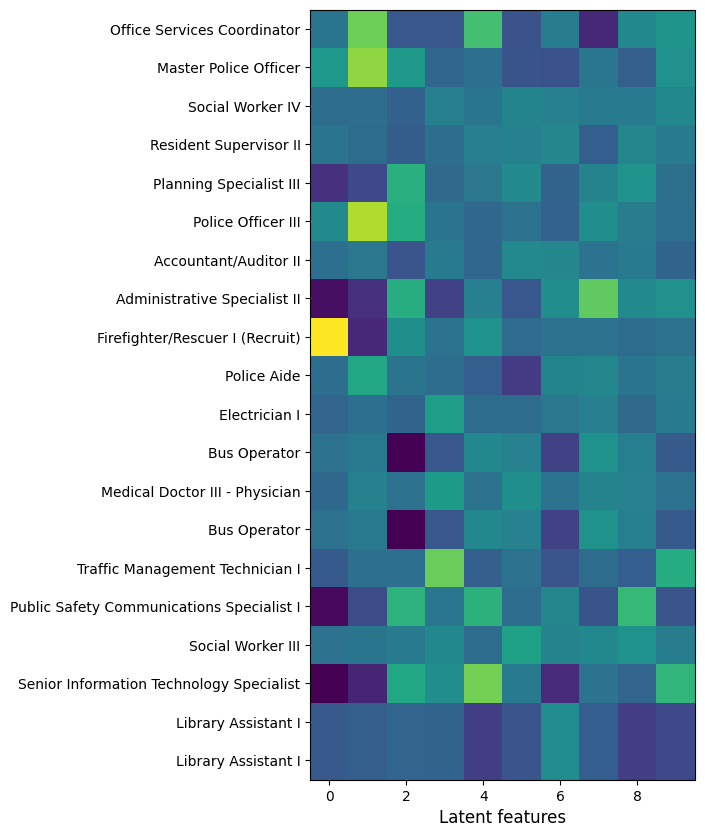

In [9]:
import matplotlib.pyplot as plt

encoded_labels = pipe.transform(x_dirty_list[:20])
plt.figure(figsize=(8, 10))
plt.imshow(encoded_labels)
plt.xlabel("Latent features", size=12)
plt.yticks(range(0, 20), labels=X_dirty[:20].to_numpy().flatten())
plt.show()

So ... it seems that the `GapEncoder` does something "more" here. So let's dive into that. 

Internally the encoder first does the countvectorizer thing where we have a bag of words of size (n_samples, vocab_size). 

But we're going to try to reduce that down to (n_samples, n_components). To do that, we're going to approximate the bag of words representation with a factorization. 

```
BAG_OF_WORDS /approx TOPIC_SAMPLE_MATRIX @ TOPIC_VOCAB_MATRIX
(n, v)               (n, t)                (t, v)
V                    H                      W 
```

You could optimise this with gradient descent, but you could also do something _extra_. 